In [ ]:
!pip install spektral torch-scatter torch-sparse torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 18.1 MB/s 
     |████████████████████████████████| 48 kB 3.7 MB/s 
     |████████████████████████████████| 407 kB 29.0 MB/s 
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=279639 sha256=9e08f9f29ce77688a0e1416c3087f384c0537af5fca391f64b2f79f140a66408
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
  Created wheel for torch-sparse: filename=torch_sparse-0.6.13-cp37-cp37m-linux_x86_64.whl size=501789 sha256=7bb64075247cc270dd2b046ecdb646931cf2368ef69876a39c9d9be3624255da
  Stored in directory: /root/.cache/pip/wheels/e0/01/be/6b2966e0ff20bb023ae35e5d17903e6e5b4df46dd5892f6be6
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=d23467757d48516fcd638a81d7efb5fd22366b4e4cb5109d06489f567c6d

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random     as rnd
import sklearn    as skl
import numpy      as np
import pandas     as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
import spektral
import spektral.transforms
import networkx as nx
import scipy
import pickle
import datetime
import torch_geometric
%load_ext tensorboard

In [ ]:
df = pd.read_hdf('cicy3o.h5')
df['matrix'] = df['matrix'].apply(lambda x: np.array(x,dtype='float32'))
df = df.sample(frac=1)

# Data Analysis

In [ ]:
df.describe()

,favour,h11,h21,isprod,kahlerpos,euler,num_cp,num_eqs,min_dim_cp,max_dim_cp,...,num_cp_2,num_cp_neq1,num_over,num_ex,min_deg_eqs,max_deg_eqs,mean_deg_eqs,median_deg_eqs,rank_matrix,norm_matrix
count,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,...,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000
mean,0.991128,7.419772,28.744740,0.002788,0.617744,-42.649937,7.368061,8.596198,1.016223,2.712041,...,2.816350,3.435108,4.228137,1.771863,2.017237,3.195437,2.274482,2.081686,7.155133,4.440265
std,0.093778,2.250891,8.577282,0.052734,0.485969,20.589891,2.170836,2.762484,0.174392,0.786964,...,1.418728,1.082787,1.072440,1.072440,0.184195,0.702082,0.298512,0.312742,2.257257,0.464088
min,0.000000,0.000000,0.000000,0.000000,0.000000,-200.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000
25%,1.000000,6.000000,23.000000,0.000000,0.000000,-52.000000,6.000000,7.000000,1.000000,2.000000,...,2.000000,3.000000,4.000000,1.000000,2.000000,3.000000,2.100000,2.000000,6.000000,4.123106
50%,1.000000,7.000000,27.000000,0.000000,1.000000,-40.000000,7.000000,8.000000,1.000000,3.000000,...,3.000000,3.000000,4.000000,2.000000,2.000000,3.000000,2.222222,2.000000,7.000000,4.472136
75%,1.000000,9.000000,33.000000,0.000000,1.000000,-28.000000,9.000000,10.000000,1.000000,3.000000,...,4.000000,4.000000,5.000000,2.000000,2.000000,4.000000,2.333333,2.000000,9.000000,4.795832
max,1.000000,19.000000,101.000000,1.000000,1.000000,0.000000,15.000000,18.000000,7.000000,7.000000,...,6.000000,6.000000,6.000000,6.000000,8.000000,8.000000,8.000000,8.000000,14.000000,6.000000


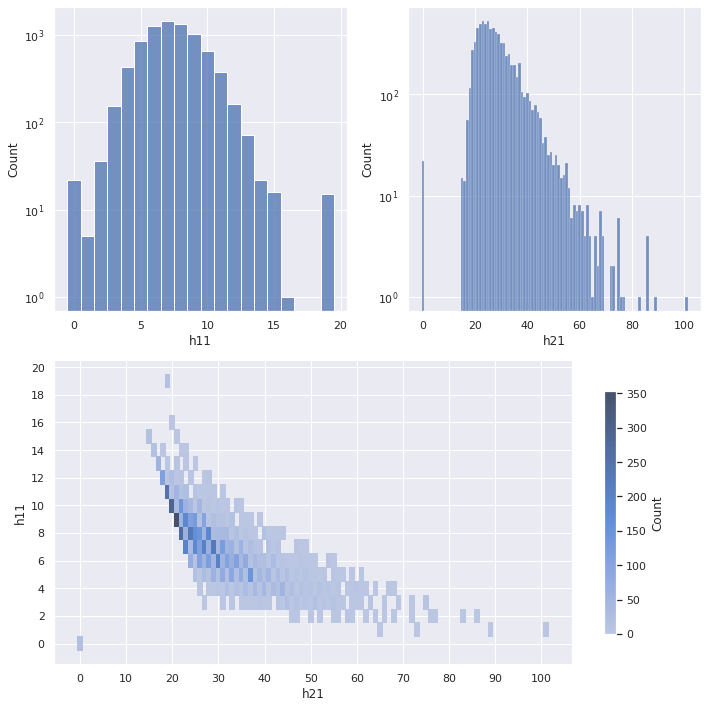

In [ ]:
sns.set()
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
ax3.yaxis.set_ticks(range(0,21,2))
ax3.xaxis.set_ticks(range(0,110,10))
sns.histplot(data = df, x = 'h11', ax = ax1, log_scale = (False,True), discrete = True)
sns.histplot(data = df, x = 'h21', ax = ax2, log_scale = (False,True), discrete = True)
sns.histplot(data = df, x = 'h21', y = 'h11', cbar = True, cbar_kws = {'label':'Count','shrink':.80}, ax = ax3, discrete = True)
fig.tight_layout()

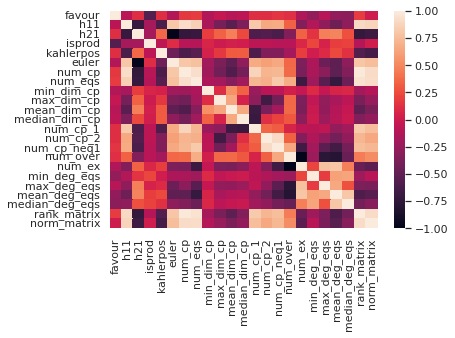

In [ ]:
sns.heatmap(df.corr(), xticklabels = 1, yticklabels = 1)

In [ ]:
rf = skl.ensemble.RandomForestRegressor()
fNames = ['num_cp', 'num_eqs', 'min_dim_cp', 'max_dim_cp', 'mean_dim_cp', 'median_dim_cp', 'num_cp_1', 'num_cp_2', 'num_cp_neq1', 'num_over', 'num_ex', 'min_deg_eqs', 'max_deg_eqs', 'mean_deg_eqs', 'median_deg_eqs', 'rank_matrix', 'norm_matrix']
xTrain = df[fNames]
yTrain1 = df['h11']
yTrain2 = df['h21']
fImportance = pd.DataFrame()
fImportance['feature'] = fNames
rf.fit(xTrain,yTrain1)
fImportance['h11'] = rf.feature_importances_
rf.fit(xTrain,yTrain2)
fImportance['h21'] = rf.feature_importances_

AttributeError: ignored

In [ ]:
fImportance = pd.melt(fImportance.sort_values(by = 'h11', ascending=False), id_vars = 'feature', var_name = 'number', value_name = 'importance')

In [ ]:
sns.barplot(data=fImportance, y = 'feature', x = 'importance', ci = None, hue = 'number')

# Neural Network

## Preprocessing

In [ ]:
def filter_outliers(data,bounds):
    df = data.copy(deep=True)
    for i in bounds:
        df = df.loc[(df[i]>=bounds[i][0]) & (data[i]<= bounds[i][1])]
    return df

def pad_and_stack(data,size):
    ar = np.ndarray(shape=(len(data),*size))
    for j in range(len(data.values)):
        x = np.array(data.values[j])
        ar[j,:,:] = np.pad(x, [(0,size[i]-x.shape[i]) for i in range(len(size))])
    return ar

In [ ]:
df_wo_outliers = filter_outliers(df,{'h11':[1,16],'h21':[1,91]})
df_wo_outliers = df_wo_outliers.sample(frac=1)
matrices = np.expand_dims(pad_and_stack(df_wo_outliers['matrix'],(12,15)),axis=3)
matrix_train, matrix_test, h11_train, h11_test, h21_train, h21_test = skl.model_selection.train_test_split(matrices, df_wo_outliers['h11'], df_wo_outliers['h21'], test_size = 0.1, shuffle = False)
matrix_train, matrix_val, h11_train, h11_val, h21_train, h21_val = skl.model_selection.train_test_split(matrix_train, h11_train, h21_train, test_size = 1/9, shuffle = False)

In [ ]:
scale = np.max(matrix_train)
matrix_train = matrix_train/scale
matrix_val = matrix_val/scale
matrix_test = matrix_test/scale

## Network

### Definition

In [ ]:
class neural_network():
    def __init__(self,name,input_shape,seq=True):
        self.name = name
        self.seq = seq
        if type(input_shape) == list:
            self.input = [keras.layers.Input(shape=x) for x in input_shape]
            self.seq=False
            self.structure = [self.input]
        elif seq:
            self.input = keras.layers.Input(shape=input_shape)
            self.middle = self.input
        else:
            self.input = [keras.layers.Input(shape=input_shape)]
            self.structure = [self.input]
    
    def add_layer(self,layer,depth=0,branch=0):
        if self.seq:
            self.middle = layer(self.middle)
        elif depth == -1:
            self.structure.append([])
            self.structure[-1].append(layer(self.structure[-2][branch]))
        else:
            if len(self.structure) <= depth+1:
                self.structure.append([])
            self.structure[depth+1].append(layer(self.structure[depth][branch]))

    def add_branch(self,layers_list,depth=0,mother_branch=0):
        if self.seq:
            for layer in layers_list:
                self.middle = layer(self.middle)
        else:
            self.add_layer(layer=layers_list[0],depth=depth,branch=mother_branch)
            for i in range(1,len(layers_list)):
                self.add_layer(layer=layers_list[i],depth=i,branch=-1)

    def add_conv_branch(self,layers_size,kernels_size,normalization=0.,dropout=0.,activation='relu',depth=0,mother_branch=0,l1reg=0.,l2reg=0.,padding='same'):
        conv_list = []
        for i in range(len(layers_size)):
            conv_list.append(keras.layers.Conv2D(filters=layers_size[i],kernel_size=kernels_size[i],activation=activation,padding=padding,kernel_regularizer=keras.regularizers.l1_l2(l1=l1reg,l2=l2reg)))
            if normalization > 0:
                conv_list.append(keras.layers.BatchNormalization(momentum=normalization))
            if dropout > 0:
                conv_list.append(keras.layers.Dropout(dropout))
        self.add_branch(conv_list,depth,mother_branch)

    def add_dense_branch(self,layers_size,dropout=0.,normalization=0.,activation='relu',depth=0,mother_branch=0,l1reg=0.,l2reg=0.):
        dense_list = []
        for i in range(len(layers_size)):
            dense_list.append(keras.layers.Dense(units=layers_size[i],activation=activation,kernel_regularizer=keras.regularizers.l1_l2(l1=l1reg,l2=l2reg)))
            if normalization > 0:
                dense_list.append(keras.layers.BatchNormalization(momentum=normalization))
            if dropout > 0:
                dense_list.append(keras.layers.Dropout(dropout))
        self.add_branch(dense_list,depth,mother_branch)

    def merge_branches(self,layer,pos_list=None):
        if pos_list == None:
            pos_list = [(-1,i) for i in range(len(self.structure[-1]))]
        depth = np.max([pos[0] for pos in pos_list])
        if depth ==-1:
            self.structure.append([])
            self.structure[-1].append(layer([self.structure[pos[0]  if pos[0] > -1 else -2][pos[1]] for pos in pos_list]))
        else:
            if len(self.structure) <= depth+1:
                self.structure.append([])
            self.structure[depth+1].append(layer([self.structure[pos[0] if pos[0] > -1 else -2][pos[1]] for pos in pos_list]))

    def close(self,outputs_position=(-1,-1)):
        self.outputs = []
        if type(outputs_position) == list:
            for i,j in outputs_position:
                self.outputs.append(self.structure[i][j])
        else:
            self.outputs = self.structure[outputs_position[0]][outputs_position[1]]

    def compile(self,optimizer=keras.optimizers.Adam,learning_rate=1e-3,metrics=['mse'],loss='mse'):
        if self.seq:
            self.model = keras.models.Model(inputs=self.input,outputs=self.middle)
        else:
            self.model = keras.models.Model(inputs=self.input,outputs=self.outputs)
        
        self.model.compile(optimizer=optimizer(learning_rate=learning_rate),loss=loss,metrics=metrics)

    def fit(self,x,y,x_val=None,y_val=None,epochs=100,early_stop=10,lr_change=5,batch_size=32):
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse',patience=early_stop,restore_best_weights=True,verbose=0),
             keras.callbacks.ReduceLROnPlateau(monitor='val_mse',patience=lr_change,factor=0.3,verbose=0),
             keras.callbacks.ModelCheckpoint(filepath='results/'+self.name+'.h5',monitor='val_mse',save_best_only=True,save_format='h5',verbose=0)
            ]
        history = self.model.fit(x,y,validation_data=(x_val,y_val),epochs=epochs,batch_size=batch_size,callbacks=callbacks)
        self.history = history.history
    
    def predict(self,x):
        prediction = self.model.predict(x)
        return np.round(prediction).astype(int).reshape(-1)
    
    def score(self,x,y):
        pred = self.predict(x)
        return np.sum(pred-y == 0)/len(pred)
    
    def plot(self,params):
        sns.lineplot(data=[self.history[param] for param in params]).set(yscale='log',xlabel='epochs',ylabel='mean square error (log)')
        plt.legend(labels=params)

### Dense neural network

In [ ]:
bull_net = neural_network(name='bull_net_f',input_shape=(15,18))
bull_net.add_layer(keras.layers.Flatten())
bull_net.add_dense_branch(layers_size=[876, 461, 437, 929, 404],dropout=0.2,normalization=0.99)
bull_net.add_layer(keras.layers.Dense(units=1,activation='relu'))
bull_net.compile()

In [ ]:
bull_net.model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 15, 18)]          0         
                                                                 
 flatten_18 (Flatten)        (None, 270)               0         
                                                                 
 dense_67 (Dense)            (None, 876)               237396    
                                                                 
 batch_normalization_136 (Ba  (None, 876)              3504      
 tchNormalization)                                               
                                                                 
 dropout_43 (Dropout)        (None, 876)               0         
                                                                 
 dense_68 (Dense)            (None, 461)               404297    
                                                          

In [ ]:
bull_net.fit(x=matrix_train,y=h11_train,x_val=matrix_val,y_val=h11_val,epochs=5000,early_stop=200,lr_change=75,batch_size=matrix_train.shape[0])

Epoch 1/5000
1/1 [==============================] - 3s 3s/step - loss: 52.0067 - mse: 52.0067 - val_loss: 59.9396 - val_mse: 59.9396 - lr: 0.0010
Epoch 2/5000
1/1 [==============================] - 1s 702ms/step - loss: 44.3763 - mse: 44.3763 - val_loss: 58.0285 - val_mse: 58.0285 - lr: 0.0010
Epoch 3/5000
1/1 [==============================] - 1s 695ms/step - loss: 33.7519 - mse: 33.7519 - val_loss: 55.4698 - val_mse: 55.4698 - lr: 0.0010
Epoch 4/5000
1/1 [==============================] - 1s 719ms/step - loss: 26.4627 - mse: 26.4627 - val_loss: 53.8058 - val_mse: 53.8058 - lr: 0.0010
Epoch 5/5000
1/1 [==============================] - 1s 744ms/step - loss: 16.8253 - mse: 16.8253 - val_loss: 52.9782 - val_mse: 52.9782 - lr: 0.0010
Epoch 6/5000
1/1 [==============================] - 1s 684ms/step - loss: 10.8473 - mse: 10.8473 - val_loss: 52.0122 - val_mse: 52.0122 - lr: 0.0010
Epoch 7/5000
1/1 [==============================] - 1s 672ms/step - loss: 9.7978 - mse: 9.7978 - val_loss: 50

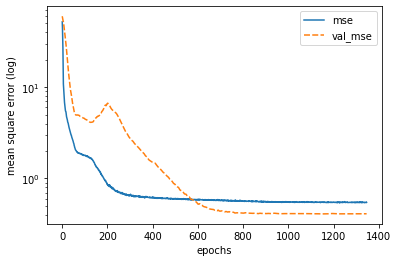

In [ ]:
bull_net.plot(['mse','val_mse'])

In [ ]:
bull_net.score(matrix_test,h11_test)

0.9694656488549618

### Convolutional Neural Network

In [ ]:
conv_net = neural_network(name='conv_net_f',input_shape=(15,18,1))
conv_net.add_layer(keras.layers.Conv2D(filters = 1, kernel_size = (2,2)))
conv_net.add_conv_branch(layers_size=[80,40,20],kernels_size=[(5,5)]*3,normalization=0.99,l1reg=1e-5,l2reg=1e-5)
conv_net.add_layer(keras.layers.Dropout(0.2))
conv_net.add_layer(keras.layers.Flatten())
conv_net.add_dense_branch(layers_size=[1000,1000,100],l1reg=1e-5,l2reg=1e-5,normalization=0.99)
conv_net.add_layer(keras.layers.Dense(units=1,activation='relu'))
conv_net.compile()

In [ ]:
conv_net.fit(x=matrix_train,y=h11_train,x_val=matrix_val,y_val=h11_val,epochs=5000,early_stop=400,lr_change=150,batch_size=32)

Epoch 1/5000
197/197 [==============================] - 9s 36ms/step - loss: 10.0566 - mse: 9.6282 - val_loss: 13.1648 - val_mse: 12.7347 - lr: 0.0010
Epoch 2/5000
197/197 [==============================] - 7s 35ms/step - loss: 4.4032 - mse: 3.9724 - val_loss: 6.5959 - val_mse: 6.1653 - lr: 0.0010
Epoch 3/5000
197/197 [==============================] - 7s 35ms/step - loss: 2.7966 - mse: 2.3640 - val_loss: 11.3844 - val_mse: 10.9506 - lr: 0.0010
Epoch 4/5000
197/197 [==============================] - 7s 35ms/step - loss: 2.0391 - mse: 1.6022 - val_loss: 4.1975 - val_mse: 3.7569 - lr: 0.0010
Epoch 5/5000
197/197 [==============================] - 7s 36ms/step - loss: 2.0356 - mse: 1.5897 - val_loss: 16.2258 - val_mse: 15.7746 - lr: 0.0010
Epoch 6/5000
197/197 [==============================] - 7s 36ms/step - loss: 1.7854 - mse: 1.3345 - val_loss: 8.5735 - val_mse: 8.1209 - lr: 0.0010
Epoch 7/5000
197/197 [==============================] - 7s 35ms/step - loss: 1.4969 - mse: 1.0422 - val_l

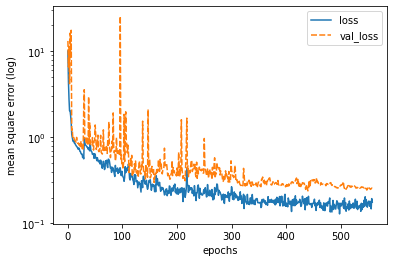

In [ ]:
params=['loss','val_loss']
sns.lineplot(data=[conv_net.history[param] for param in params]).set(yscale='log',xlabel='epochs',ylabel='mean square error (log)')
plt.legend(labels=params)

In [ ]:
conv_net.score(matrix_test,h11_test)

0.9834605597964376

### Inception Network

In [ ]:
inc_net = neural_network(name='inception_f',input_shape=(15,18,1),seq=False)
inc_net.add_conv_branch(layers_size=[32,64,32],kernels_size=[(15,1)]*3,normalization=0.99,l1reg=1e-4,l2reg=1e-4)
inc_net.add_conv_branch(layers_size=[32,64,32],kernels_size=[(1,18)]*3,normalization=0.99,l1reg=1e-4,l2reg=1e-4)
inc_net.merge_branches(layer=keras.layers.Concatenate())
inc_net.add_layer(layer=keras.layers.Flatten(),depth=-1)
inc_net.add_layer(keras.layers.Dense(units=1,activation='relu'),depth=-1)
inc_net.close()
inc_net.compile()

2022-05-20 15:23:44.280954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-20 15:23:44.281002: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-20 15:23:44.281040: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (is225557): /proc/driver/nvidia/version does not exist
2022-05-20 15:23:44.281449: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
inc_net.fit(x=matrix_train,y=h11_train,x_val=matrix_val,y_val=h11_val,epochs=5000,early_stop=400,lr_change=150,batch_size=32)

Epoch 1/5000
197/197 [==============================] - 22s 113ms/step - loss: 0.8737 - mse: 0.4384 - val_loss: 9.6478 - val_mse: 9.2152 - lr: 0.0010
Epoch 2/5000
197/197 [==============================] - 24s 123ms/step - loss: 0.8707 - mse: 0.4408 - val_loss: 1.5508 - val_mse: 1.1242 - lr: 0.0010
Epoch 3/5000
197/197 [==============================] - 25s 125ms/step - loss: 0.9160 - mse: 0.4926 - val_loss: 1.2250 - val_mse: 0.8052 - lr: 0.0010
Epoch 4/5000
197/197 [==============================] - 25s 129ms/step - loss: 0.8850 - mse: 0.4692 - val_loss: 1.0691 - val_mse: 0.6571 - lr: 0.0010
Epoch 5/5000
197/197 [==============================] - 25s 126ms/step - loss: 0.8642 - mse: 0.4564 - val_loss: 0.9165 - val_mse: 0.5131 - lr: 0.0010
Epoch 6/5000
197/197 [==============================] - 24s 121ms/step - loss: 0.7811 - mse: 0.3824 - val_loss: 1.7595 - val_mse: 1.3661 - lr: 0.0010
Epoch 7/5000
197/197 [==============================] - 24s 123ms/step - loss: 0.7447 - mse: 0.3562 

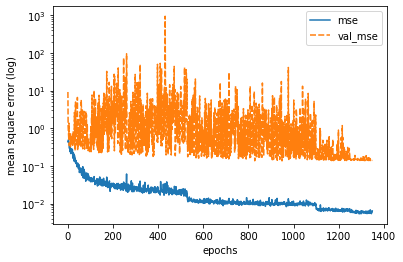

In [ ]:
inc_net.plot(['mse','val_mse'])

In [ ]:
inc_net.score(matrix_test,h11_test)

0.9796437659033079

In [ ]:
inc_net.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 18, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 15, 18, 32)   512         ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 15, 18, 32)   608         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 15, 18, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                   

# Graphs

## Data

### Graph creation

In [ ]:
def mat_to_graph1(matrices):
    if type(matrices) == np.ndarray:
        nodes_features = []
        edges_list = []
        edges_features = []
        rows = matrices.shape[0]
        columns = matrices.shape[1]
        nodes_features += [[0,1]]*rows + [[1,0]]*columns
        for i in range(rows):
            for j in range(columns):
                if matrices[i][j] > 0:
                    edges_list.append([i,rows+j])
                    edges_features.append([matrices[i][j]])
        edges_list,edges_features = spektral.utils.reorder(edge_index=np.array(edges_list),edge_features=np.array(edges_features))
        sparse_adj = scipy.sparse.coo_matrix(([1]*len(edges_features),(edges_list[:,0],edges_list[:,1])),shape=(len(nodes_features),len(nodes_features)))
        sparse_adj += sparse_adj.T
        mod_sparse_adj = scipy.sparse.coo_matrix((np.squeeze(edges_features,axis=1),(edges_list[:,0],edges_list[:,1])),shape=(len(nodes_features),len(nodes_features)))
        mod_sparse_adj += mod_sparse_adj.T
        return {'nodes':nodes_features,'edges_list':edges_list,'edges_features':edges_features,'adj_mat':sparse_adj,'mod_adj_mat':mod_sparse_adj}
    else:
        graph_list = []
        for mat in matrices:
            graph_list.append(mat_to_graph1(mat))
        return graph_list

def mat_to_graph2(matrices):
    if type(matrices) == np.ndarray:
        nodes_features = []
        edges_list = []
        edges_features = []
        rows = matrices.shape[0]
        columns = matrices.shape[1]
        node_num_mat = np.zeros(matrices.shape,dtype='float32')
        node_num = 0
        for i in range(rows):
            for j in range(columns):
                if matrices[i][j] > 0:
                    node_num_mat[i,j] = node_num
                    nodes_features.append([matrices[i][j]])
                    for k in range(0,i):
                        if matrices[k][j] > 0:
                            edges_list.append([node_num_mat[k,j],node_num])
                            edges_features.append([1,0])
                            edges_list.append([node_num,node_num_mat[k,j]])
                            edges_features.append([1,0])
                    for k in range(0,j):
                        if matrices[i][k] > 0:
                            edges_list.append([node_num_mat[i,k],node_num])
                            edges_features.append([0,1])
                            edges_list.append([node_num,node_num_mat[i,k]])
                            edges_features.append([0,1])
                    node_num += 1
        edges_list,edges_features = spektral.utils.reorder(edge_index=np.array(edges_list),edge_features=np.array(edges_features))
        sparse_adj = scipy.sparse.coo_matrix(([1]*len(edges_features),(edges_list[:,0],edges_list[:,1])),shape=(len(nodes_features),len(nodes_features)))
        return {'nodes':nodes_features,'edges_list':edges_list,'edges_features':edges_features,'adj_mat':sparse_adj}
    else:
        graph_list = []
        for mat in matrices:
            graph_list.append(mat_to_graph2(mat))
        return graph_list

def graph_to_mat1(graph):
    rows = 0
    columns = 0
    for node in graph['nodes']:
        if node == [0,1]:
            rows += 1
        else:
            columns += 1
    matrice = np.zeros((rows,columns))
    for i in range(len(graph['edges_list'])):
        pos = graph['edges_list'][i]
        matrice[pos[0],pos[1]-rows] = graph['edges_features'][i]
    return matrice

def check_graph_mat1(graph,mat):
    return (graph_to_mat1(graph)==mat).all()

def df_to_list(df):
    graphs_list = mat_to_graph1(list(df['matrix'].values))
    for i in range(len(graphs_list)):
        graphs_list[i]['h11'] = df['h11'].values[i]
        graphs_list[i]['h21'] = df['h21'].values[i]
    return graphs_list

In [ ]:
graphs_list = df_to_list(df)

In [ ]:
for i in range(len(graphs_list)):
    check = check_graph_mat1(graphs_list[i],df['matrix'].values[i])
    if not check:
        print('Error',graphs_list[i],df['matrix'].values[i])

In [ ]:
ind = rnd.randint(0,7889)
df['matrix'].values[ind]

In [ ]:
G = nx.from_scipy_sparse_matrix(graphs_list[ind]['adj_mat'])
nx.draw(G)

### Spektral data

In [ ]:
class ef_dataset(spektral.data.Dataset):
    def __init__(self,graphs_list,labels):
        self.graphs_list = graphs_list
        self.labels = labels
        super().__init__()
    
    def read(self):
        return [spektral.data.Graph(x=np.array(graph['nodes'],dtype='float32'),a=graph['adj_mat'],e=graph['edges_features'],y=graph[self.labels]) for graph in self.graphs_list]

class adj_dataset(spektral.data.Dataset):
    def __init__(self,graphs_list,labels):
        self.graphs_list = graphs_list
        self.labels = labels
        super().__init__()
    
    def read(self):
        return [spektral.data.Graph(x=np.array(graph['nodes'],dtype='float32'),a=graph['mod_adj_mat'],y=graph[self.labels]) for graph in self.graphs_list]

def create_dataset(graphs_list,target,regression=True,edges_features=False,remove_outliers=True):
    if edges_features:
        dataset = ef_dataset(graphs_list,target)
    else:
        dataset = adj_dataset(graphs_list,target)
    if remove_outliers:
        if target == 'h11':
            min_val,max_val=1,16
        else:
            min_val,max_val=1,91
        dataset.filter(lambda g: g.y <= max_val and g.y >= min_val)
    if not regression:
        dataset.apply(spektral.transforms.OneHotLabels(labels=list(range(min_val,max_val+1))))
    return dataset

def loading(dataset,ratio=(0.8,0.1)):
    val = round(ratio[0]*len(dataset))
    test = round((ratio[0]+ratio[1])*len(dataset))
    dataset_train = dataset[:val]
    dataset_val = dataset[val:test]
    dataset_test = dataset[test:]
    loader = spektral.data.DisjointLoader(dataset_train,batch_size=32,shuffle=True)
    val_loader = spektral.data.DisjointLoader(dataset_val,batch_size=32,shuffle=True)
    test_loader = spektral.data.DisjointLoader(dataset_test,batch_size=32,shuffle=True)
    return loader,val_loader,test_loader
  
class OneHotEdges:
    def __init__(self,max_edge):
        self.max_edge = max_edge

    def __call__(self, graph):
        if "e" not in graph:
            raise ValueError("The graph must have edges features")
        features = graph.e.astype(int).squeeze()
        graph.e = spektral.utils.one_hot(features,self.max_edge+1)
        return graph

In [ ]:
dataset = create_dataset(graphs_list,'h21',edges_features=False,regression=True)
max_degree = int(dataset.map(lambda g: g.a.sum(-1).max(), reduce=max))
dataset.apply(spektral.transforms.Degree(max_degree))

In [ ]:
max_edge = int(dataset.map(lambda g: g.e.max(), reduce=max))
dataset.apply(OneHotEdges(max_edge))

In [ ]:
loader,val_loader,test_loader = loading(dataset)

### Torch Data

In [ ]:
from torch_geometric.data import Data

## Network

In [ ]:
import keras.backend as K
def acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [ ]:
class MyFirstGNN(keras.models.Model):
    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = spektral.layers.GCNConv(2*n_hidden,activation='relu')
        self.graph_conv2 = spektral.layers.GCNConv(n_hidden,activation='relu')
        self.chebconv = spektral.layers.ChebConv(32,K=5,activation='relu')
        self.gconv = spektral.layers.GeneralConv(dropout=0.3,kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))
        self.xenet = spektral.layers.XENetConv(stack_channels=16,node_channels=16,edge_channels=16)
        self.eccconv = spektral.layers.ECCConv(32,[100,50,100])
        self.pool = spektral.layers.GlobalSumPool()
        self.dropout = keras.layers.Dropout(0.5)
        self.dense1 = keras.layers.Dense(512)
        self.dense2 = keras.layers.Dense(512)
        self.dense3 = keras.layers.Dense(256,activation='relu',kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))
        self.dense4 = keras.layers.Dense(n_labels,activation='relu')

    def call(self, inputs):
        x,a,i = inputs
        #out = self.graph_conv((x,a))
        #out = self.gconv((x,a))
        A = tf.make_ndarray(tf.sparse.to_dense(a))
        pols = spektral.utils.convolution.chebyshev_filter(A,5)
        out = self.chebconv((x,pols))
        #out = self.graph_conv2((out,a))
        #out = self.xenet([x,a,e])
        #out = self.eccconv([x,a,e])
        #out = self.dropout(out)
        out = self.pool([out,i])
        #out = self.dense1(out)
        #out = self.dense2(out)
        out = self.dense3(out)
        out = self.dense4(out)
        return out

class graph_model(keras.models.Model):
    def __init__(self,disjoint_loading=False,pooling_layer=None):
        super().__init__()
        self.disjoint_loading = disjoint_loading

    def call(self,inputs):
        if self.disjoint_loading:
            pass
        else:
            return super().call(inputs)

In [ ]:
class graph_neural_network(neural_network):
    def __init__(self,name,input_shape,seq=True):
        super().__init__(name,input_shape,seq)
    
    def fit(self,loader,val_loader=None,epochs=100,early_stop=10,lr_change=5):
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse',patience=early_stop,restore_best_weights=True,verbose=0),
                     keras.callbacks.ReduceLROnPlateau(monitor='val_mse',patience=lr_change,factor=0.3,verbose=0),
                     keras.callbacks.ModelCheckpoint(filepath='results/'+self.name+'.h5',monitor='val_mse',save_best_only=True,save_format='h5',verbose=0)
                    ]
        self.history = self.model.fit(loader.load(),validation_data=val_loader.load(),epochs=epochs,callbacks=callbacks,steps_per_epoch=loader.steps_per_epoch,validation_steps=val_loader.steps_per_epoch)

    def add_layer(self,layer,depth=0,branch=0,disjoint_pooling=False):
        if disjoint_pooling:
            if self.seq:
                self.middle = layer([self.middle,self.disjoint_structure])
            elif depth == -1:
                self.structure.append([])
                self.structure[-1].append(layer(self.structure[-2][branch]))
            else:
                if len(self.structure) <= depth+1:
                    self.structure.append([])
                self.structure[depth+1].append(layer(self.structure[depth][branch]))
        else:
            super().add_layer(layer,depth,branch)

    def compile(self,optimizer=keras.optimizers.Adam,learning_rate=1e-3,metrics=['mse'],loss='mse'):
        if self.seq:
            self.model = graph_model(inputs=self.input,outputs=self.middle)
        else:
            self.model = graph_model(inputs=self.input,outputs=self.outputs)
        self.model.compile(optimizer=optimizer(learning_rate=learning_rate),loss=loss,metrics=metrics)

NameError: ignored

In [ ]:
reg = True
if reg:
    firstGNN = MyFirstGNN(64,1)
    loss = 'mse'
    metric = acc
else:
    firstGNN = MyFirstGNN(64,max_val-min_val+1)
    loss = 'categorical_crossentropy'
    metric = 'acc'
firstGNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=loss,metrics=[metric])
callbacks = [keras.callbacks.EarlyStopping(monitor='val_acc',min_delta=0.02,patience=100,restore_best_weights=True,verbose=0),
             keras.callbacks.ReduceLROnPlateau(monitor='val_acc',min_delta=0.02,patience=50,factor=0.3,verbose=0),
             keras.callbacks.TensorBoard(log_dir="logs/fit/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))]

In [ ]:
#%tensorboard --logdir logs
firstGNN.fit(loader.load(),epochs=500,validation_data=val_loader.load(),steps_per_epoch=loader.steps_per_epoch,validation_steps=val_loader.steps_per_epoch,callbacks=callbacks)

Epoch 1/500


AttributeError: ignored

In [ ]:
result = firstGNN.predict(test_loader.load(),steps=test_loader.steps_per_epoch)

/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'adj_dataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


In [ ]:
firstGNN.evaluate(test_loader.load(),steps=test_loader.steps_per_epoch)

21/25 [========================>.....] - ETA: 0s - loss: 22.4930 - acc: 0.1190

/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'adj_dataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


25/25 [==============================] - 0s 8ms/step - loss: 21.1154 - acc: 0.1155


[21.115421295166016, 0.11546052992343903]

In [ ]:
l = []
for graph in dataset[round(0.9*len(dataset)):]:
    l.append(graph.y)

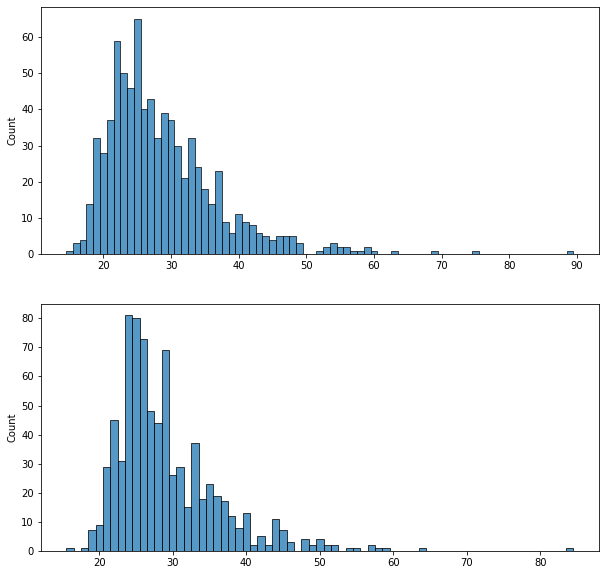

In [ ]:
fig = plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.histplot(x=l,discrete=True)
plt.subplot(212)
sns.histplot(x=np.round(result).squeeze(),discrete=True)